# Transfer leaning이란
- ImageNet과 같은 데이터셋에 이미 학습되어있는 모델(가중치)를 가져와 내가 학습시키려는 데이터셋을 추가학습 시키는 방법
- 두 데이터셋은 서로 다르지만 유사한 특징들이 있을 것이므로 랜덤한 초깃값으로 학습을 시작하는 경우보다 효과적
- 특히 데이터셋의 크기가 작을 경우 충분한 학습이 불가하므로 유용하게 쓰인다. 

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

# 데이터 불러오기 및 전처리

In [96]:
#URL로부터 데이터셋 다운로드
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

#train, validation 데이터셋의 경로
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

#배치사이즈, 이미지 크기
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

#train dataset 불러오기
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
#validation dataset 불러오기
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


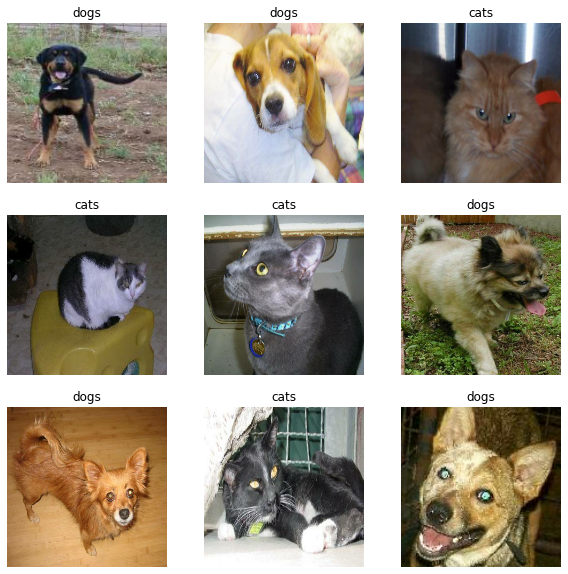

In [97]:
#데이터셋의 클래스명 ['cats', 'dogs']
class_names = train_dataset.class_names

#샘플 데이터 확인하기
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [98]:
val_batches = tf.data.experimental.cardinality(validation_dataset) #사용가능한 데이터 배치 수 확인
test_dataset = validation_dataset.take(val_batches // 5) #20%만 test 데이터셋으로 사용
validation_dataset = validation_dataset.skip(val_batches // 5) #나머지는 validation dataset

In [99]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [100]:
#prefetch: 훈련시키는 동안 다음 데이터들을 준비시켜 효율적인 학습을 돕는다. AUTOTUNE으로 설정 시 가져올 요소의 수를 동적으로 조정.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [101]:
#데이터 증강
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'), #수평 방향으로 뒤집기
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2), #0.2*2pi만큼 랜덤하게 회전
])

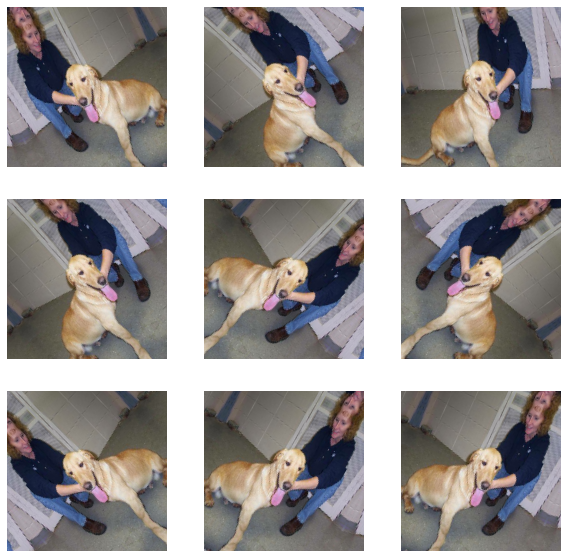

In [102]:
#데이터 증강 결과 확인
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# 모델

In [103]:
#전처리
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1) #[-1, 1]로 픽셀값 조정


In [136]:
# Imagenet에 사전학습된 MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [137]:
# 160x160x3 이미지를 input으로 넣으면 5x5x1280의 output => 특징추출
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [106]:
#베이스 모델 freeze(학습x)
base_model.trainable = False

In [107]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [108]:
#분류를 위한 레이어 추가
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() #각 채널마다 픽셀값을 평균
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [109]:
#이중 분류이므로 하나의 값을 출력하는 FC layer를 추가
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [110]:
#모델 재구성
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs) #증대
x = preprocess_input(x) #정규화
x = base_model(x, training=False) #기존 모델
x = global_average_layer(x) #채널별 평균
x = tf.keras.layers.Dropout(0.2)(x) #드롭아웃
outputs = prediction_layer(x) #FC layer
model = tf.keras.Model(inputs, outputs)

# 모델 학습

In [111]:
#컴파일
base_learning_rate = 0.0001 #학습률
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [112]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0   

In [113]:
#학습 전 정확도 0.54
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 41ms/step - loss: 0.6979 - accuracy: 0.5446


In [114]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.70
initial accuracy: 0.54


In [115]:
#10에폭 훈련
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 8s 73ms/step - loss: 0.6375 - accuracy: 0.6195 - val_loss: 0.4744 - val_accuracy: 0.6906
Epoch 2/10
63/63 [==============================] - 5s 74ms/step - loss: 0.4727 - accuracy: 0.7435 - val_loss: 0.3544 - val_accuracy: 0.7908
Epoch 3/10
63/63 [==============================] - 5s 74ms/step - loss: 0.3912 - accuracy: 0.8110 - val_loss: 0.2774 - val_accuracy: 0.8626
Epoch 4/10
63/63 [==============================] - 5s 73ms/step - loss: 0.3168 - accuracy: 0.8515 - val_loss: 0.2327 - val_accuracy: 0.8861
Epoch 5/10
63/63 [==============================] - 5s 73ms/step - loss: 0.2867 - accuracy: 0.8645 - val_loss: 0.1901 - val_accuracy: 0.9134
Epoch 6/10
63/63 [==============================] - 5s 74ms/step - loss: 0.2485 - accuracy: 0.8955 - val_loss: 0.1657 - val_accuracy: 0.9282
Epoch 7/10
63/63 [==============================] - 5s 73ms/step - loss: 0.2293 - accuracy: 0.8960 - val_loss: 0.1437 - val_accuracy: 0.9394
Epoch 8/10
63

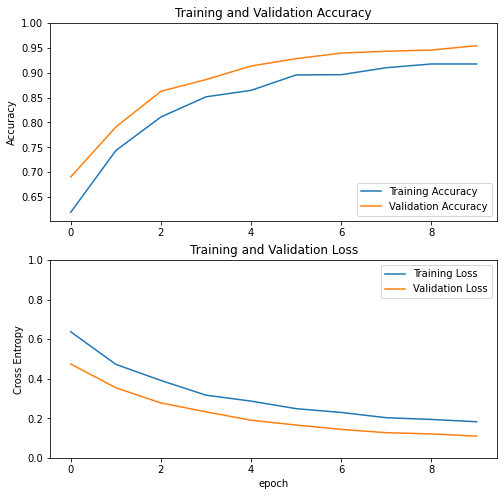

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 미세조정(Fine Tuning)

In [117]:
#베이스 모델 학습 가능하도록 변경
base_model.trainable = True

In [118]:
#컴파일
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10), #학습률 1/10
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [119]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0   

In [120]:
#추가 훈련
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 21s 163ms/step - loss: 0.1521 - accuracy: 0.9335 - val_loss: 0.0589 - val_accuracy: 0.9802
Epoch 11/20
63/63 [==============================] - 10s 150ms/step - loss: 0.1136 - accuracy: 0.9530 - val_loss: 0.0649 - val_accuracy: 0.9765
Epoch 12/20
63/63 [==============================] - 10s 150ms/step - loss: 0.0903 - accuracy: 0.9640 - val_loss: 0.0431 - val_accuracy: 0.9827
Epoch 13/20
63/63 [==============================] - 10s 147ms/step - loss: 0.0884 - accuracy: 0.9650 - val_loss: 0.0513 - val_accuracy: 0.9802
Epoch 14/20
63/63 [==============================] - 10s 149ms/step - loss: 0.0632 - accuracy: 0.9760 - val_loss: 0.0514 - val_accuracy: 0.9790
Epoch 15/20
63/63 [==============================] - 10s 149ms/step - loss: 0.0619 - accuracy: 0.9755 - val_loss: 0.0393 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 10s 147ms/step - loss: 0.0546 - accuracy: 0.9730 - val_loss: 0.0487 - val_accuracy:

In [121]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

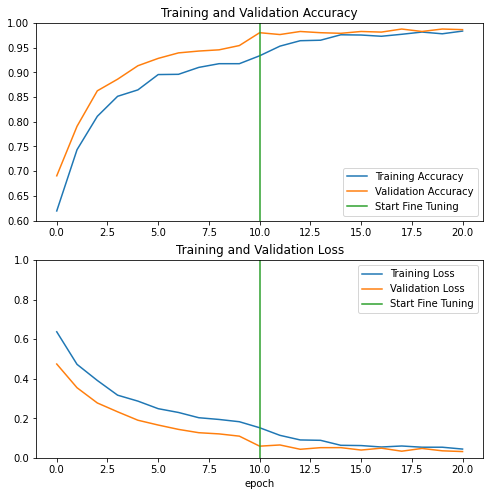

In [123]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 평가 및 예측

In [124]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 51ms/step - loss: 0.0299 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [1 1 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1]
Labels:
 [1 1 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1]


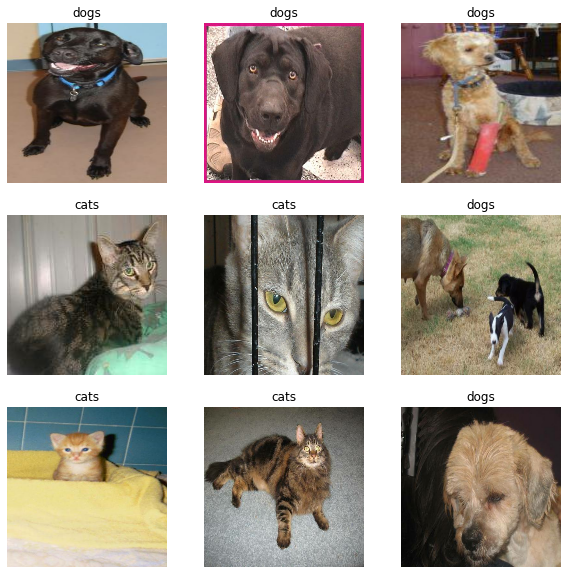

In [125]:
#test 데이터셋 예측
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# sigmoid를 거친 후 0.5미만이면 0, 0.5이상이면 1로 분류
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")